In [19]:
import yfinance as yt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
# download data
df = yt.download("AMZN", start = "2022-01-01")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03 00:00:00-05:00,167.550003,170.703506,166.160507,170.404495,170.404495,63520000
2022-01-04 00:00:00-05:00,170.438004,171.399994,166.349503,167.522003,167.522003,70726000
2022-01-05 00:00:00-05:00,166.882996,167.126495,164.356995,164.356995,164.356995,64302000
2022-01-06 00:00:00-05:00,163.450500,164.800003,161.936996,163.253998,163.253998,51958000
2022-01-07 00:00:00-05:00,163.839005,165.243500,162.031006,162.554001,162.554001,46606000


Text(0, 0.5, 'Close price')

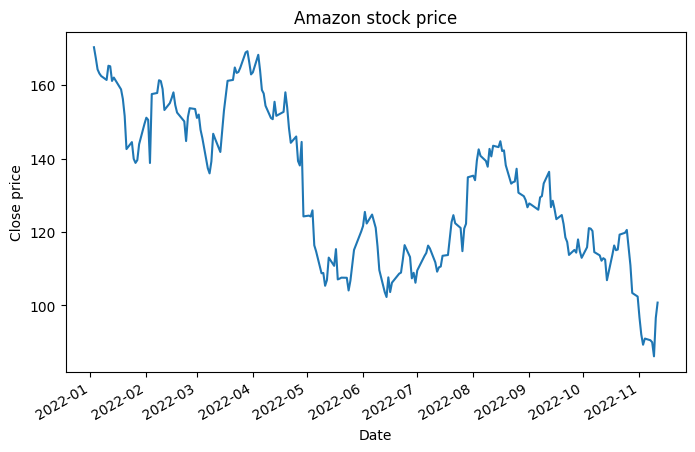

In [21]:
# plot data
fig = plt.figure()
ax = fig.add_subplot(111)
df["Close"].plot(figsize = (8, 5))
plt.title("Amazon stock price")
plt.ylabel("Close price")

In [22]:
# simple strat based on open and close each day
for i, row in df.iterrows():
    if(row["Open"] - row["Close"] < 0):
        df.at[i, "simple_strat_position"] = 1
    else:
        df.at[i, "simple_strat_position"] = -1

In [23]:
# implement simple strat
df["daily_change"] = df["Close"] - df["Open"] # change in value over the day
df["profit_simple_strat"] = df.simple_strat_position.shift(1) * df.daily_change # profit on one day is change in value of that day multiplied by our position
df["return_simple_strat"] = df["profit_simple_strat"].cumsum() # total returns of strategy
df["return_holding_stock"] = [(i-df.iloc[0]["Open"]) for i in df.Open] # return from buying and holding

Text(0, 0.5, 'Returns')

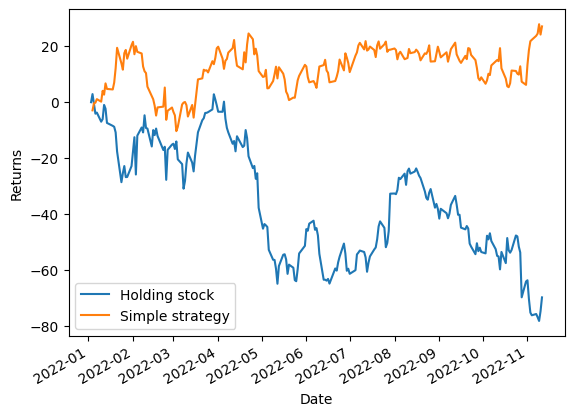

In [24]:
# plot our strat vs holding
df.plot(y = ["return_holding_stock", "return_simple_strat"], label = ["Holding stock", "Simple strategy"])
plt.ylabel("Returns")

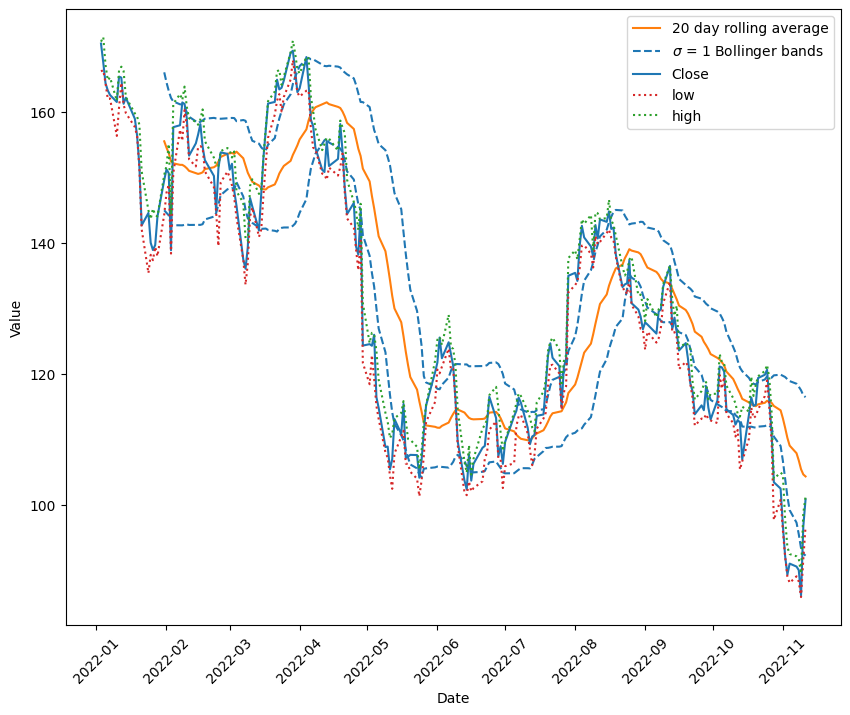

In [25]:
# Calculate Bollinger bands with N = 20 and K = 2
N = 20
K = 1
df["rolling_mean"] = df["Close"].rolling(window=N).mean()
df["rolling_std"] = df["Close"].rolling(window=N).std()
df["lower_bollinger"] = df.rolling_mean - K * df.rolling_std
df["upper_bollinger"] = df.rolling_mean + K * df.rolling_std

# plot graph
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
blue = '#1f77b4'
orange = '#ff7f0e'
red = '#d62728'
green = '#2ca02c'
ax.plot(df.rolling_mean.index, df.rolling_mean, label = "{} day rolling average".format(N), color = orange)
ax.plot(df.lower_bollinger.index, df.lower_bollinger, linestyle = "--", color = blue, label = r"$\sigma$ = {} Bollinger bands".format(K))
ax.plot(df.upper_bollinger.index, df.upper_bollinger, linestyle = "--", color = blue)
ax.plot(df.index, df["Close"], label = "Close", color = blue)
ax.plot(df.index, df["Low"], linestyle = ":", color = red, label = "low")
ax.plot(df.index, df["High"], linestyle = ":", color = green, label = 'high')
ax.set_ylabel("Value")
ax.set_xlabel("Date")
ax.legend()
plt.xticks(rotation = 45)
plt.show()


In [26]:
# create strategy based off bolinger bands
counter = 0
long_pos = False
short_pos = False
total_long_positions = 0
total_short_positions = 0
for i, row in df.iterrows():

    # do nothing for the first 20 days
    if counter < N:
        df.at[i, "profit_bollinger_strat"] = 0

    # if low falls below lower band
    elif(df.at[i, "Low"] < df.at[i, "lower_bollinger"]):

        low = df.at[i, "Low"]

        # if we have a short pos and we can profit, close it
        if short_pos and short_price > low:
            short_pos = False
            total_short_positions -= 1
            df.at[i, "profit_bollinger_strat"] = short_price - low
        else:
            df.at[i, "profit_bollinger_strat"] = 0

        # if we don't have a long position, open one
        if not long_pos:
            long_pos = True
            long_price = low
            total_long_positions += 1
            long_date = i

    # if high goes above upper band
    elif(df.at[i, "High"] > df.at[i, "upper_bollinger"]):

        high = df.at[i, "High"]

        # if we have a long pos and we can profit, close it
        # or if we exceed the risk
        if long_pos and high > long_price:
            long_pos = False
            total_long_positions -= 1
            df.at[i, "profit_bollinger_strat"] = high - long_price
        else:
            df.at[i, "profit_bollinger_strat"] = 0

        # open short pos
        if not short_pos:
            short_pos = True
            short_price = high
            total_short_positions += 1
            short_date = i

    # if between bands
    else:
        df.at[i, "profit_bollinger_strat"] = 0

    counter += 1

# find cummulative returns
df["return_bollinger_strat"] = df["profit_bollinger_strat"].cumsum()

# check for open and close positions
if total_long_positions > 0:
    print("Warning: {} open long position(s)".format(total_long_positions))
    print(short_date)
if total_short_positions > 0:
    print("Warning: {} open short position(s)".format(total_short_positions))
    print(long_date)

print(df.return_bollinger_strat.max())


2022-10-18 00:00:00-04:00
116.90599822998047


Text(0, 0.5, 'Returns')

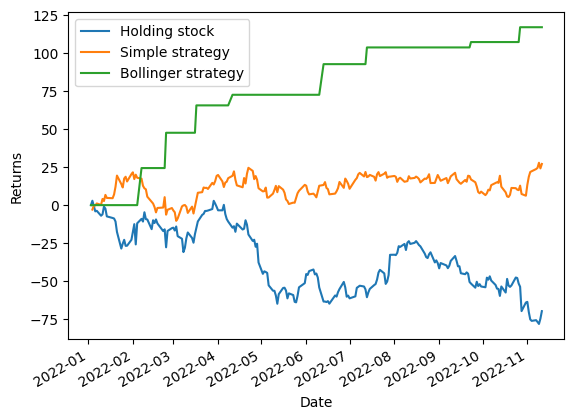

In [27]:
df.plot(y = ["return_holding_stock", "return_simple_strat", "return_bollinger_strat"], label = ["Holding stock", "Simple strategy", "Bollinger strategy"])
plt.ylabel("Returns")

In [ ]:
# create strategy based off bolinger bands
counter = 0
long_pos = False
short_pos = False
total_long_positions = 0
total_short_positions = 0
for i, row in df.iterrows():

    # do nothing for the first 20 days
    if counter < N:
        df.at[i, "profit_bollinger_strat"] = 0

    # if low falls below lower band
    elif(df.at[i, "Low"] < df.at[i, "lower_bollinger"]):

        low = df.at[i, "Low"]

        # if we have a short pos and we can profit, close it
        if short_pos and short_price > low:
            short_pos = False
            total_short_positions -= 1
            df.at[i, "profit_bollinger_strat"] = short_price - low
        else:
            df.at[i, "profit_bollinger_strat"] = 0

        # if we don't have a long position, open one
        if not long_pos:
            long_pos = True
            long_price = low
            total_long_positions += 1
            long_date = i

    # if high goes above upper band
    elif(df.at[i, "High"] > df.at[i, "upper_bollinger"]):

        high = df.at[i, "High"]

        # if we have a long pos and we can profit, close it
        # or if we exceed the risk
        if long_pos and high > long_price:
            long_pos = False
            total_long_positions -= 1
            df.at[i, "profit_bollinger_strat"] = high - long_price
        else:
            df.at[i, "profit_bollinger_strat"] = 0

        # open short pos
        if not short_pos:
            short_pos = True
            short_price = high
            total_short_positions += 1
            short_date = i

    # if between bands
    else:
        df.at[i, "profit_bollinger_strat"] = 0

    counter += 1

# find cummulative returns
df["return_bollinger_strat"] = df["profit_bollinger_strat"].cumsum()